In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/taxi_data"

In [3]:
import dask.dataframe as dd
import dask
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pandas.plotting import register_matplotlib_converters

<ipython-input-3-217196fabfb2>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Reading and Processing The Data:

In [ ]:
ddf=dd.read_parquet('drive/MyDrive/nyc_taxi_alt')

In [ ]:
ddf.head(10)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-01-01 00:46:40   2019-01-01 00:53:20              1.0   
1         1  2019-01-01 00:59:47   2019-01-01 01:18:59              1.0   
2         2  2018-12-21 13:48:30   2018-12-21 13:52:40              3.0   
3         2  2018-11-28 15:52:25   2018-11-28 15:55:45              5.0   
4         2  2018-11-28 15:56:57   2018-11-28 15:58:33              5.0   
5         2  2018-11-28 16:25:49   2018-11-28 16:28:26              5.0   
6         2  2018-11-28 16:29:37   2018-11-28 16:33:43              5.0   
7         1  2019-01-01 00:21:28   2019-01-01 00:28:37              1.0   
8         1  2019-01-01 00:32:01   2019-01-01 00:45:39              1.0   
9         1  2019-01-01 00:57:32   2019-01-01 01:09:32              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.5         1.0                  N           151           239   
1            2.6         1.0                  N           239           246   
2            0.0         1.0                  N           236           236   
3            0.0         1.0                  N           193           193   
4            0.0         2.0                  N           193           193   
5            0.0         1.0                  N           193           193   
6            0.0         2.0                  N           193           193   
7            1.3         1.0                  N           163           229   
8            3.7         1.0                  N           229             7   
9            2.1         1.0                  N           141           234   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          7.0    0.5      0.5        1.65          0.00   
1             1         14.0    0.5      0.5        1.00          0.00   
2             1          4.5    0.5      0.5        0.00          0.00   
3             2          3.5    0.5      0.5        0.00          0.00   
4             2         52.0    0.0      0.5        0.00          0.00   
5             2          3.5    0.5      0.5        0.00          5.76   
6             2         52.0    0.0      0.5        0.00          0.00   
7             1          6.5    0.5      0.5        1.25          0.00   
8             1         13.5    0.5      0.5        3.70          0.00   
9             1         10.0    0.5      0.5        1.70          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    0.3          9.95                   NaN          NaN  
1                    0.3         16.30                   NaN          NaN  
2                    0.3          5.80                   NaN          NaN  
3                    0.3          7.55                   NaN          NaN  
4                    0.3         55.55                   NaN          NaN  
5                    0.3         13.31                   NaN          NaN  
6                    0.3         55.55                   NaN          NaN  
7                    0.3          9.05                   NaN          NaN  
8                    0.3         18.50                   NaN          NaN  
9                    0.3         13.00                   NaN          NaN

In [ ]:
def build_info_ddf(ddf):
    # Notice how we are building the whole info dataframe lazily
    info_ddf = dd.from_pandas(pd.DataFrame(ddf.dtypes), npartitions=1)
    # identifying the missing values from the dataset.
    info_ddf['total_observations'] = ddf.index.size

    info_ddf['missing_val'] = ddf.isnull().sum()

    info_ddf['missing_val_ratio'] = (info_ddf['missing_val'] / ddf.index.size * 100).round().astype(int)


    # renaming the first column using rename()
    info_ddf = info_ddf.rename(columns = {0:'data_type'})

    return info_ddf

In [ ]:
with ProgressBar():
  df = build_info_ddf(ddf).compute()
df

[########################################] | 100% Completed | 121.95 s


data_type  total_observations  missing_val  \
DOLocationID                    int64           179311700            0   
PULocationID                    int64           179311700            0   
RatecodeID                    float64           179311700      3872186   
VendorID                        int64           179311700            0   
airport_fee                   float64           179311700    115760994   
congestion_surcharge          float64           179311700      8660504   
extra                         float64           179311700            0   
fare_amount                   float64           179311700            0   
improvement_surcharge         float64           179311700            0   
mta_tax                       float64           179311700            0   
passenger_count               float64           179311700      3872186   
payment_type                    int64           179311700            0   
store_and_fwd_flag             object           179311700      3872186   
tip_amount                    float64           179311700            0   
tolls_amount                  float64           179311700            0   
total_amount                  float64           179311700            0   
tpep_dropoff_datetime  datetime64[ns]           179311700            0   
tpep_pickup_datetime   datetime64[ns]           179311700            0   
trip_distance                 float64           179311700            0   

                       missing_val_ratio  
DOLocationID                           0  
PULocationID                           0  
RatecodeID                             2  
VendorID                               0  
airport_fee                           65  
congestion_surcharge                   5  
extra                                  0  
fare_amount                            0  
improvement_surcharge                  0  
mta_tax                                0  
passenger_count                        2  
payment_type                           0  
store_and_fwd_flag                     2  
tip_amount                             0  
tolls_amount                           0  
total_amount                           0  
tpep_dropoff_datetime                  0  
tpep_pickup_datetime                   0  
trip_distance                          0

In [ ]:
lookup=pd.read_csv('drive/MyDrive/taxi_zone_lookup.csv')
lookup.loc[lookup.Zone.isin(['JFK Airport','LaGuardia Airport'])]

LocationID Borough               Zone service_zone
131         132  Queens        JFK Airport     Airports
137         138  Queens  LaGuardia Airport     Airports

In [ ]:
jfk_airport=132
laguardia=138

In [ ]:
def fill_airport(x):
  if x==jfk_airport or x==laguardia:
    return 1.25
  else:
    return 0

In [ ]:
def get_PULocationID_partition(se):
  values=se.apply(fill_airport)
  return values

in the apply method if we used it on series it is the same as apply with axis=1 if we apply it on datafame but without indexing like we dont use x[0] to get the first value in dataframe with axis=1 we only write x because it's one value at time

In [ ]:
ddf["airport_fee"] = ddf["PULocationID"].map_partitions(get_PULocationID_partition,meta=('airport_fee','float64'))

In [ ]:
with ProgressBar():
  df=build_info_ddf(ddf).compute()
df

In [ ]:
ddf=ddf.dropna().reset_index(drop=True)

In [ ]:
ddf=ddf.loc[(ddf.total_amount >0)].reset_index(drop=True)

In [ ]:
with ProgressBar():
  max1,min1=dask.compute(ddf.total_amount.max(),ddf.total_amount.min())
max1,min1

[########################################] | 100% Completed | 175.66 s


### Remove Outliers from total_amount and date columns using IQR method

In [ ]:
with ProgressBar():
  # q1,q3=dask.compute(ddf.total_amount.quantile(0.25),ddf.total_amount.quantile(0.75))
  #without drop:
  q1=16.9
  q3=34.6
  #with drop
  # q1=15.95
  # q3=39.85
  IQR=1.5 * (q3 -q1)
  lower_limit= q1 - IQR
  upper_limit= q3 + IQR

In [ ]:
upper_limit

61.150000000000006

In [ ]:
lower_limit

-9.650000000000006

In [ ]:
q1,q3

(16.9, 34.6)

In [ ]:
ddf=ddf.loc[
    (ddf.tpep_pickup_datetime.dt.year <=2022) &
    (ddf.tpep_pickup_datetime.dt.year >=2019) &
    (ddf.tpep_dropoff_datetime.dt.year <=2022) &
    (ddf.tpep_dropoff_datetime.dt.year >=2019) &
    (ddf.total_amount >= lower_limit) &
    (ddf.total_amount <= upper_limit)].reset_index(drop=True)

### i prepeared Two data for the time sereis one i droped the null values and one i didn't because i didn't understand why to drop samples from the data because of columns we don't even need it in the series like the passengers count ...etc
### but i stuck to the series that built from no null data :)

---



### Writing Data wihout Drop:

In [ ]:
# with ProgressBar():
#   ddf.to_parquet('drive/MyDrive/without_drop_null_taxi')

[########################################] | 100% Completed | 438.29 s


### Writing Data with Drop:

In [ ]:
# with ProgressBar():
#   ddf.to_parquet('drive/MyDrive/no_null_taxi')

### without drop Null data:

In [ ]:
ddf=dd.read_parquet('drive/MyDrive/without_drop_null_taxi')

### With Drop:

In [ ]:
ddf=dd.read_parquet('drive/MyDrive/no_null_taxi')

## Exploring The Data:

In [ ]:
with ProgressBar():
  max_value,min_value=dask.compute(ddf.total_amount.max(),ddf.total_amount.min())

[########################################] | 100% Completed | 17.36 s


In [ ]:
max_value,min_value

(75.7, 0.01)

In [ ]:
with ProgressBar():
  df=build_info_ddf(ddf).compute()
df

## Building The Time Series:

In [ ]:
ddf['year'] = ddf['tpep_pickup_datetime'].dt.year
ddf['month'] = ddf['tpep_pickup_datetime'].dt.month
ddf['day'] = ddf['tpep_pickup_datetime'].dt.day
ddf['hour'] = ddf['tpep_pickup_datetime'].dt.hour

In [ ]:
number_of_journeys=ddf[['VendorID','year','month','day','hour','tpep_pickup_datetime']].groupby(['VendorID','year','month','day','hour']).size().reset_index()[0]

In [ ]:
ddf2=ddf[['VendorID','year','month','day','hour','total_amount']].groupby(['VendorID','year','month','day','hour']).sum().reset_index()

In [ ]:
ddf2['number_of_journeys']=number_of_journeys

In [ ]:
ddf2=ddf2.reset_index(drop=True)

### Writing Data without Drop:

In [ ]:
with ProgressBar():
  ddf2.to_parquet('drive/MyDrive/final_series_no_drop/parquets')

[########################################] | 100% Completed | 207.94 s


### Writing Data With Drop

In [ ]:
with ProgressBar():
  ddf2.to_parquet('drive/MyDrive/final_series/parquets')

## Converting the Data To CSV wide format(without Drop):

In [ ]:
df=pd.read_parquet('drive/MyDrive/final_series_no_drop/parquets').reset_index(drop=True)

In [ ]:
df.to_csv('drive/MyDrive/final_series_no_drop/series_wide_no_drop.csv',index=None)

## Converting the Data To CSV wide format(With Drop):

In [ ]:
df=pd.read_parquet('drive/MyDrive/final_series/parquets').reset_index(drop=True)

In [ ]:
df.to_csv('drive/MyDrive/final_series/series_wide.csv',index=None)

Reading The Time Serires:
======================================================================================================================================================

With Drop:

In [ ]:
df=pd.read_csv('drive/MyDrive/final _series/series_wide.csv')

Without Drop:

In [ ]:
df=pd.read_csv('drive/MyDrive/final_series_no_drop/series_wide_no_drop.csv')

### Processin The Data:

In [ ]:
df=df.sort_values(['VendorID','year','month','day','hour'],ascending=[True,True,True,True,True])

In [ ]:
df

VendorID  year  month  day  hour  total_amount  number_of_journeys
0             1  2019      1    1     7          7.30                   1
1             1  2019      1    3    21         18.10                   2
2             1  2019      1    3    22         25.30                   2
3             1  2019      1    5     3         17.15                   2
4             1  2019      1    5     4         28.55                   2
...         ...   ...    ...  ...   ...           ...                 ...
67419         2  2022     12   31    19      84134.66                3804
67420         2  2022     12   31    20      90228.70                3911
67421         2  2022     12   31    21      86985.84                3689
67422         2  2022     12   31    22      71931.93                2799
67423         2  2022     12   31    23      45768.68                1908

[67424 rows x 7 columns]

In [ ]:
df['date']=pd.to_datetime(df[['year','month','day','hour']])

In [ ]:
df.insert(0,'date',df.pop('date'))

In [ ]:
df.drop(['year','month','day','hour'],axis=1,inplace=True)

In [ ]:
df

date  VendorID  total_amount  number_of_journeys
0     2019-01-01 07:00:00         1          7.30                   1
1     2019-01-03 21:00:00         1         18.10                   2
2     2019-01-03 22:00:00         1         25.30                   2
3     2019-01-05 03:00:00         1         17.15                   2
4     2019-01-05 04:00:00         1         28.55                   2
...                   ...       ...           ...                 ...
67419 2022-12-31 19:00:00         2      84134.66                3804
67420 2022-12-31 20:00:00         2      90228.70                3911
67421 2022-12-31 21:00:00         2      86985.84                3689
67422 2022-12-31 22:00:00         2      71931.93                2799
67423 2022-12-31 23:00:00         2      45768.68                1908

[67424 rows x 4 columns]

# Note: Time Series processing techniques is moved to Exploration and analysis section with ACF and PACF

### Save The data as Long CSV file (with Drop):

In [ ]:
# df_long = pd.melt(df, id_vars=['date','VendorID'])
# df.to_csv('drive/MyDrive/final_series/final_series_wide.csv',index=None)
# df_long.to_csv('drive/MyDrive/final_series/final_series_long.csv',index=None)

### Save The data as Long CSV file (without Drop):

In [ ]:
# df_long = pd.melt(df, id_vars=['date','VendorID'])
# df.to_csv('drive/MyDrive/final_series_no_drop/final_series_wide_no_drop.csv',index=None)
# df_long.to_csv('drive/MyDrive/final_series_no_drop/final_series_long_no_drop.csv',index=None)

## 2. Feature Engeneering on the Real Data:

In [83]:
ddf=dd.read_parquet('drive/MyDrive/no_null_taxi')
lookup=pd.read_csv('drive/MyDrive/taxi_zone_lookup.csv')

### 2. 1-2-3-4

In [ ]:
zones_ids={}
borough_ids={}
def zone_borough_to_dict(labels):
  id=labels[0]
  zone_name=labels[1]
  borough=labels[2]
  zones_ids[id]=zone_name
  borough_ids[id]=borough

In [ ]:
lookup[['LocationID','Zone','Borough']].apply(zone_borough_to_dict,axis=1)

In [ ]:
zones_ids[265]="UNKOWN"
borough_ids[265]="UNKOWN"

In [ ]:
def add_source_dist_zones(id):
  return zones_ids[id]

In [ ]:
def get_Pickup_down_location_partition_for_zone(se):
  values=se.apply(add_source_dist_zones)
  return values

In [ ]:
def add_source_dist_borough(id):
  return borough_ids[id]

In [ ]:
def get_Pickup_down_location_partition_for_borough(se):
  values=se.apply(add_source_dist_borough)
  return values

In [ ]:
ddf["source_zone"] = ddf["PULocationID"].map_partitions(get_Pickup_down_location_partition_for_zone ,meta=('source_zone','object'))
ddf["destination_zone"] = ddf["DOLocationID"].map_partitions(get_Pickup_down_location_partition_for_zone ,meta=('destination_zone','object'))
ddf["source_borough"] = ddf["PULocationID"].map_partitions(get_Pickup_down_location_partition_for_borough,meta=('source_borough','object'))
ddf["destination_borough"] = ddf["DOLocationID"].map_partitions(get_Pickup_down_location_partition_for_borough,meta=('destination_borough','object'))

In [ ]:
with ProgressBar():
  ddf.to_parquet('four_features')

### Read The four features data

In [ ]:
ddf=dd.read_parquet('four_feature')

### 2. 5

In [ ]:
def add_pair_zone(labels):
  source_zone=labels[0]
  dist_zone=labels[1]
  first=min(source_zone,dist_zone)
  second=max(source_zone,dist_zone)
  return first + ',' + second

In [ ]:
def get_pair_ids_partition_for_zone(df):
  values=df[['source_zone','destination_zone']].apply(add_pair_zone,axis=1)
  return values

In [ ]:
ddf["location_pair"] = ddf[["source_zone","destination_zone"]].map_partitions(get_pair_ids_partition_for_zone,meta=('location_pair','object'))

### 2. 6

In [ ]:
def add_payment_type_name(pay_type):
  if pay_type == 1:
    return "credit_card"
  elif pay_type ==2:
    return 'cash'
  elif pay_type == 3:
    return 'No charge'
  elif pay_type == 4:
    return 'Dispute'
  elif pay_type == 6:
    return "Voided tri"
  else:
    return "Unkown"

In [ ]:
def get_payment_type_partition(se):
  values=se.apply(add_payment_type_name)
  return values

In [ ]:
ddf["payment_type_name"] = ddf['payment_type'].map_partitions(get_payment_type_partition,meta=('payment_type_name','object'))

### 2.7

In [ ]:
def add_vendor(id):
  if id ==1:
    return "Creative Mobile Technologies"
  elif id==2:
    return "VeriFone"
  else:
    return "UNKOWN"

In [ ]:
def get_vendor_id_partition(se):
  values=se.apply(add_vendor)
  return values

In [ ]:
ddf["vendor"] = ddf['VendorID'].map_partitions(get_vendor_id_partition,meta=('vendor','object'))

### 2.8

In [ ]:
def add_rate_code(id):
  if id==1:
    return "Standard rate"
  elif id==2:
    return "JFK"
  elif id==3:
    return "Newark"
  elif id==4:
    return "Nassau or Westchester"
  elif id==5:
    return "Negotiated fare"
  elif id==6:
    return "Group ride"
  else:
    return "UNKOWN"

In [ ]:
def get_rate_code_id_partition(se):
  values=se.apply(add_rate_code)
  return values

In [ ]:
ddf["rate_code"] = ddf['RatecodeID'].map_partitions(get_rate_code_id_partition,meta=('rate_code','object'))

In [ ]:
with ProgressBar():
  ddf.to_parquet('eight_features')

[########################################] | 100% Completed | 31m 1s


### read The Eight features data

In [ ]:
ddf=dd.read_parquet('eight_features')


In [ ]:
ddf.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7722: UserWarning: Insufficient elements for `head`. 5 elements requested, only 1 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-01-01 07:01:20   2019-01-31 14:29:21              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N            48           163   

   payment_type  ...  congestion_surcharge  airport_fee   source_zone  \
0             2  ...                   0.0          0.0  Clinton East   

   destination_zone  source_borough  destination_borough  \
0     Midtown North       Manhattan            Manhattan   

                location_pair  payment_type_name  \
0  Clinton East,Midtown North               cash   

                         vendor      rate_code  
0  Creative Mobile Technologies  Standard rate  

[1 rows x 27 columns]

### 2.9

In [7]:
with ProgressBar():
  pair=ddf[['location_pair']].groupby('location_pair').size().reset_index().compute()

[########################################] | 100% Completed | 146.04 s


In [8]:
pair.rename(columns={0:"count"},inplace=True)

In [9]:
pair.sort_values(by=['count'],ascending=[False])

location_pair    count
4693         Upper East Side North,Upper East Side South  2105816
3592           Lincoln Square East,Upper West Side South   896318
55                  Midtown Center,Upper East Side South   893200
43           Upper West Side North,Upper West Side South   872654
4679                                     Unknown,Unknown   868160
...                                                  ...      ...
26985  Marine Park/Floyd Bennett Field,Murray Hill-Qu...        1
26983                          Inwood Hill Park,Rosedale        1
26982                   Inwood Hill Park,Jamaica Estates        1
26981                          Hollis,Van Cortlandt Park        1
28599                            Freshkills Park,Midwood        1

[28600 rows x 2 columns]

In [10]:
pair['count'].describe()

count    2.860000e+04
mean     5.808313e+03
std      3.786200e+04
min      1.000000e+00
25%      8.000000e+00
50%      4.900000e+01
75%      3.150000e+02
max      2.105816e+06
Name: count, dtype: float64

In [ ]:
# pd.qcut(pair['count'],q=4).head()

0    (315.0, 2105816.0]
1    (315.0, 2105816.0]
2    (315.0, 2105816.0]
3    (315.0, 2105816.0]
4    (315.0, 2105816.0]
Name: count, dtype: category
Categories (4, interval[float64, right]): [(0.999, 8.0] < (8.0, 49.0] < (49.0, 315.0] <
                                           (315.0, 2105816.0]]

In [52]:
locations_pairs={}
def location_pair_to_dic(labels):
  location=labels[0]
  count=labels[1]
  locations_pairs[location]=count

In [53]:
pair[['location_pair','count']].apply(location_pair_to_dic,axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
28595    None
28596    None
28597    None
28598    None
28599    None
Length: 28600, dtype: object

In [60]:
def add_trip_class(trip_name):
  count=locations_pairs[trip_name]
  if count >30000:
    return "more_common"
  elif count >=20000:
    return "common"
  elif count>=10000:
    return "less_common"
  else:
    return "rare"

In [61]:
def get_location_pair_num(se):
  values=se.apply(add_trip_class)
  return values

In [62]:
ddf["trip_class"] = ddf['location_pair'].map_partitions(get_location_pair_num,meta=('trip_class','object'))

### 2.10

In [29]:
def add_trip_time(times):
  pick=times[0]
  down=times[1]
  delta=pick-down
  time_difference=np.absolute(delta.total_seconds())
  return time_difference // 60

In [30]:
def get_pick_down_time_partiation(df):
  values=df[['tpep_pickup_datetime','tpep_dropoff_datetime']].apply(add_trip_time,axis=1)
  return values

In [31]:
ddf["trip_time"] = ddf[['tpep_pickup_datetime','tpep_dropoff_datetime']].map_partitions(get_pick_down_time_partiation,meta=('trip_time','int64'))

### 2.11

In [ ]:
def convert_to_km(distance):
  return distance * 1.60934

In [ ]:
def get_distance_partition(se):
  values=se.apply(convert_to_km)
  return values

In [ ]:
ddf["trip_distance"] = ddf['trip_distance'].map_partitions(get_distance_partition,meta=('trip_distance','float64'))

In [63]:
with ProgressBar():
  ddf.to_parquet('final_features')

[########################################] | 100% Completed | 11m 5s


# 3 discover and analysis:

In [64]:
ddf=dd.read_parquet('final_features')

In [59]:
ddf=dd.read_parquet('drive/MyDrive/final_features')

In [65]:
with ProgressBar():
  v=ddf.trip_class.value_counts().compute()
v

[########################################] | 100% Completed | 47.62 s


more_common    142453633
rare            11544149
less_common      6696970
common           5422987
Name: trip_class, dtype: int64

In [ ]:
ddf.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:7722: UserWarning:

Insufficient elements for `head`. 5 elements requested, only 1 elements available. Try passing larger `npartitions` to `head`.



VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-01-01 07:01:20   2019-01-31 14:29:21              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0       1.931208         1.0                  N            48           163   

   payment_type  ...   source_zone  destination_zone  source_borough  \
0             2  ...  Clinton East     Midtown North       Manhattan   

   destination_borough               location_pair  payment_type_name  \
0            Manhattan  Clinton East,Midtown North               cash   

                         vendor      rate_code   trip_class trip_time  
0  Creative Mobile Technologies  Standard rate  more_common     43648  

[1 rows x 29 columns]

## 3. 1

In [ ]:
with ProgressBar():
  vendor_amount=ddf[['vendor','total_amount']].groupby('vendor').sum().reset_index().compute()

In [ ]:
with ProgressBar():
  vendor_journeys=ddf[['vendor','total_amount']].groupby('vendor').size().reset_index().compute()

[########################################] | 100% Completed | 72.86 s


In [ ]:
vendor_journeys.rename(columns={0:'number_of_journeys'},inplace=True)

#### For Total_amount:

In [ ]:
fig = px.pie(vendor_amount, values="total_amount", names="vendor")
fig.show()

#### For Number Of Journeys:

In [ ]:
fig = px.pie(vendor_journeys, values="number_of_journeys", names="vendor")
fig.show()

## 3.2

#### for Source Borough Total Amount:

In [ ]:
with ProgressBar():
  borough_amount=ddf[['source_borough','total_amount']].groupby('source_borough').sum().reset_index().compute()

[########################################] | 100% Completed | 59.36 s


In [ ]:
fig = px.pie(borough_amount, values="total_amount", names="source_borough")
fig.show()

#### For Destination Borough Total Amount :

In [ ]:
with ProgressBar():
  borough_amount=ddf[['destination_borough','total_amount']].groupby('destination_borough').sum().reset_index().compute()

[########################################] | 100% Completed | 105.15 s


In [ ]:
fig = px.pie(borough_amount, values="total_amount", names="destination_borough")
fig.show()

#### for Source Borough Number Of Journeys:

In [ ]:
with ProgressBar():
  borough_journeys=ddf[['source_borough','total_amount']].groupby('source_borough').size().reset_index().compute()

[########################################] | 100% Completed | 78.35 s


In [ ]:
borough_journeys.rename(columns={0:'number_of_journeys'},inplace=True)

In [ ]:
fig = px.pie(borough_journeys, values="number_of_journeys", names="source_borough")
fig.show()

#### For Destination Borough number of journeys :

In [ ]:
with ProgressBar():
  borough_journeys=ddf[['destination_borough','total_amount']].groupby('destination_borough').size().reset_index().compute()

[########################################] | 100% Completed | 46.95 s


In [ ]:
borough_journeys.rename(columns={0:'number_of_journeys'},inplace=True)

In [ ]:
fig = px.pie(borough_journeys, values="number_of_journeys", names="destination_borough")
fig.show()

## 3.3

In [ ]:
with ProgressBar():
  pay_methods=ddf[['payment_type_name']].groupby('payment_type_name').size().reset_index().compute()
pay_methods.rename(columns={0:'count'},inplace=True)

[########################################] | 100% Completed | 49.08 s


In [ ]:
fig = px.bar(pay_methods, x = "payment_type_name", y = "count")
fig.show()

## 3.4

In [66]:
with ProgressBar():
  pay_trip_class_methods=ddf[['payment_type_name','trip_class','total_amount']].groupby(['payment_type_name','trip_class']).size().reset_index().compute()

[########################################] | 100% Completed | 73.26 s


In [67]:
pay_trip_class_methods.rename(columns={0:'count'},inplace=True)

In [68]:
fig = px.sunburst(pay_trip_class_methods, path=['payment_type_name', 'trip_class'],
                  values='count')
fig.show()

## 3. 5

In [ ]:
with ProgressBar():
  corr_matrix=ddf.corr().compute()

In [ ]:
# i=['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
#        'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
#        'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
#        'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration']

# corr_matrix.to_csv('drive/MyDrive/correlation.csv',index=i)

In [ ]:
corr_matrix=pd.read_csv('drive/MyDrive/correlation.csv')

In [ ]:
corr_matrix.rename(columns={'Unnamed: 0':''},inplace=True)

In [ ]:
corr_matrix.set_index('',inplace=True)

In [ ]:
required_corr=corr_matrix[['total_amount','tip_amount','passenger_count','trip_time','trip_distance']].loc[['total_amount','tip_amount','passenger_count','trip_time','trip_distance']]

##### trip_time == trip_duration

In [ ]:
required_corr

total_amount  tip_amount  passenger_count  trip_time  \
                                                                        
total_amount         1.000000    0.663205         0.011861   0.111665   
tip_amount           0.663205    1.000000        -0.002524   0.053098   
passenger_count      0.011861   -0.002524         1.000000   0.011249   
trip_time            0.111665    0.053098         0.011249   1.000000   
trip_distance        0.093915    0.051715         0.001394   0.011120   

                 trip_distance  
                                
total_amount          0.093915  
tip_amount            0.051715  
passenger_count       0.001394  
trip_time             0.011120  
trip_distance         1.000000

In [ ]:
import plotly.express as px
fig = px.imshow(required_corr, x=required_corr.columns, y=required_corr.index)
fig.update_layout(width=500,height=500)
fig.show()

## 3. 6

#### Mean:

In [69]:
with ProgressBar():
  df1=ddf[['total_amount','trip_time','trip_distance','trip_class']].groupby('trip_class').mean().reset_index().compute()
df1['statistics_type']=['mean' for x in range(0,len(df1))]

[########################################] | 100% Completed | 66.50 s


In [ ]:
# df1.to_csv('drive/MyDrive/mean_taxi.csv',index=None)

In [ ]:
df1=pd.read_csv('drive/MyDrive/mean_taxi.csv')

#### Median:

In [ ]:
with ProgressBar():
  d=ddf[['trip_time','trip_class']].copy().compute()

[########################################] | 100% Completed | 42.23 s


In [ ]:
with ProgressBar():
  df2=ddf[['total_amount','trip_time','trip_distance','trip_class']].groupby('trip_class').median().reset_index().compute()


[####################################### ] | 99% Completed | 115.77 s

In [ ]:
df2['statistics_type']=['median' for x in range(0,len(df2))]


#### Std:

In [75]:
with ProgressBar():
  df3=ddf[['total_amount','trip_time','trip_distance','trip_class']].groupby('trip_class').std().reset_index().compute()
df3['statistics_type']=['std' for x in range(0,len(df3))]

[########################################] | 100% Completed | 80.05 s


In [71]:
# df3.to_csv('drive/MyDrive/std_taxi.csv',index=None)

In [76]:
df=pd.concat([df1,df3],axis=0)
df

trip_class  total_amount   trip_time  trip_distance statistics_type
0  more_common     17.018448   14.756284       3.853179            mean
1         rare     32.134623   29.263082      11.215966            mean
2  less_common     25.424419   23.033108       8.228438            mean
3       common     26.655404   23.612470       8.844743            mean
0  more_common     11.279816   77.253080      41.330047             std
1         rare     14.476586  177.398991     152.915330             std
2  less_common     12.429594   70.566961      20.783158             std
3       common     14.774229   68.692002      23.933458             std

##### trip_time == trip_duration

In [77]:
fig = px.bar(df, x="trip_class", y=['total_amount','trip_time','trip_distance'],facet_col='statistics_type')
fig.show()

## 3.7

In [78]:
df=pd.read_csv('drive/MyDrive/final_series/final_series_wide.csv')
df['date']=pd.to_datetime(df['date'])

### seprate The data into two agency

In [79]:
first_agency=df.loc[(df.VendorID ==1)]
first_agency.set_index('date',inplace=True)
first_agency=first_agency.asfreq('h').interpolate(method='linear')

In [80]:
second_agency=df.loc[(df.VendorID== 2)]
second_agency.set_index('date',inplace=True)
second_agency=second_agency.asfreq('h').interpolate(method='linear')

### downsampling the data into Monthly-Weekly-Daily:

In [81]:
first_agency_smoothed_monthly=first_agency.resample('M').mean()
first_agency_smoothed_weekly=first_agency.resample('W').mean()
first_agency_smoothed_daily=first_agency.resample('D').mean()

In [82]:
second_agency_smoothed_monthly=second_agency.resample('M').mean()
second_agency_smoothed_weekly=second_agency.resample('W').mean()
second_agency_smoothed_daily=second_agency.resample('D').mean()

### Daily Data:

### First Agency:

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(first_agency_smoothed_daily['total_amount'])

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

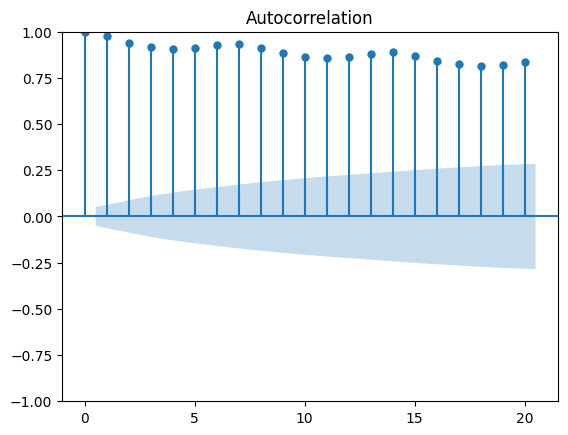

In [ ]:
plot_acf(first_agency_smoothed_daily['total_amount'], lags=20);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



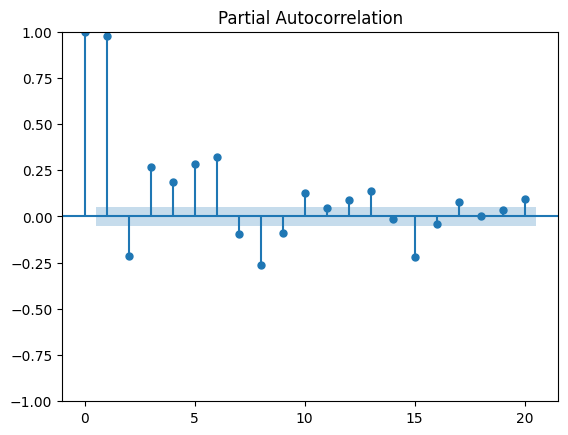

In [ ]:
plot_pacf(first_agency_smoothed_daily['total_amount'], lags=20);

### ADF is bigger than the 5% so:

In [ ]:
diff_close = np.diff(first_agency_smoothed_daily['total_amount'], n=1)

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(diff_close)

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -11.086303840556303
p-value: 4.18853113276587e-20


{'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}

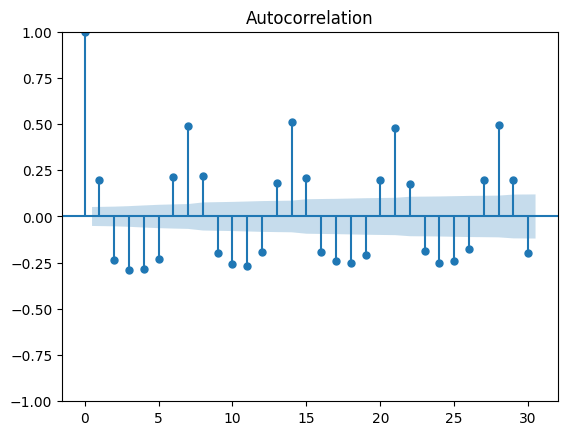

In [ ]:
plot_acf(diff_close, lags=30);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



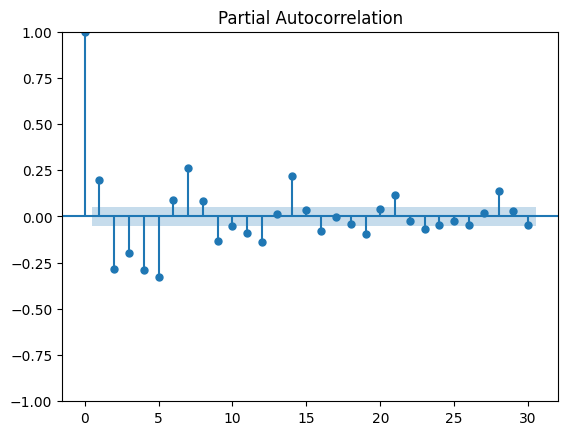

In [ ]:
plot_pacf(diff_close, lags=30);

### Second Agency:

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(second_agency_smoothed_daily['total_amount'])

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -1.9049825608677056
p-value: 0.32972079956984146


{'1%': -3.4349602407782758,
 '5%': -2.8635761009296763,
 '10%': -2.5678540089914974}

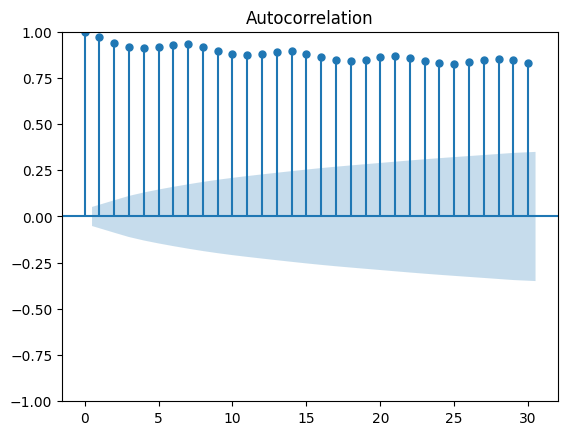

In [ ]:
plot_acf(second_agency_smoothed_daily['total_amount'], lags=30);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


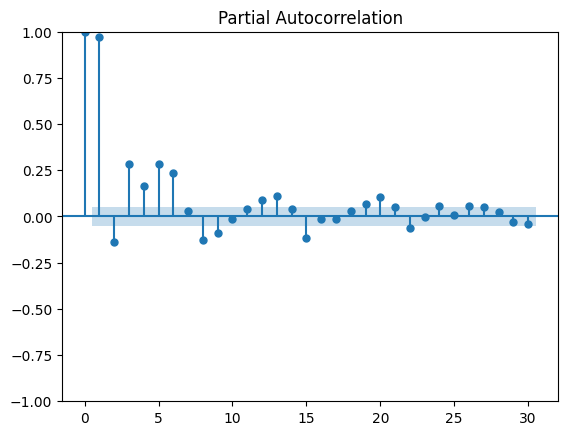

In [ ]:
plot_pacf(second_agency_smoothed_daily['total_amount'], lags=30);

### ADF is bigger than the 5% so:

In [ ]:
diff_close = np.diff(second_agency_smoothed_daily['total_amount'], n=1)

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(diff_close)

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -10.454727389793733
p-value: 1.408304701630246e-18


{'1%': -3.434966750462565,
 '5%': -2.8635789736973725,
 '10%': -2.5678555388041384}

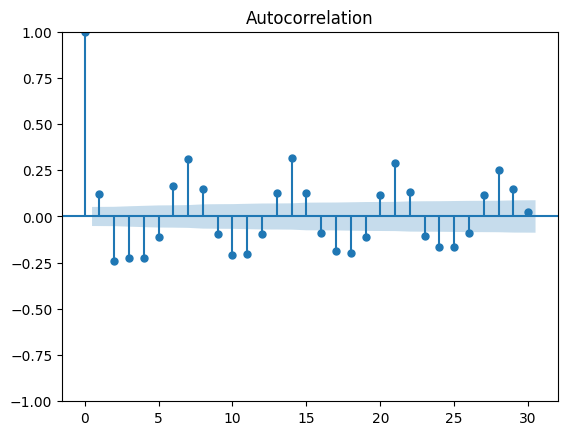

In [ ]:
plot_acf(diff_close, lags=30);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


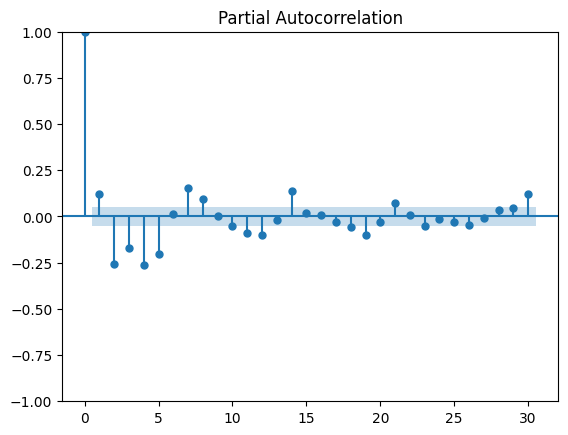

In [ ]:
plot_pacf(diff_close, lags=30);

### Monthly Data:

### First Agency:

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(first_agency_smoothed_monthly['total_amount'])

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -2.485690198687999
p-value: 0.11899498940827974


{'1%': -3.5812576580093696,
 '5%': -2.9267849124681518,
 '10%': -2.6015409829867675}

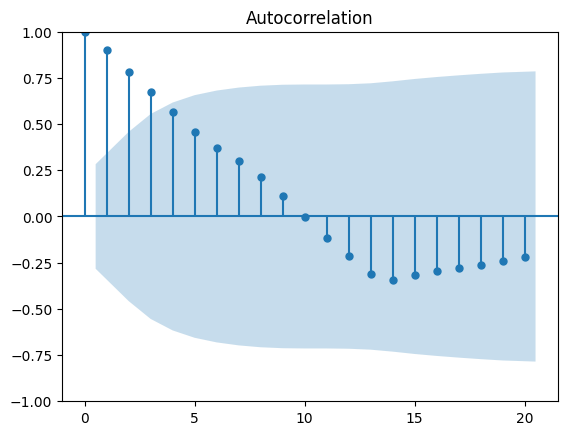

In [ ]:
plot_acf(first_agency_smoothed_monthly['total_amount'], lags=20);

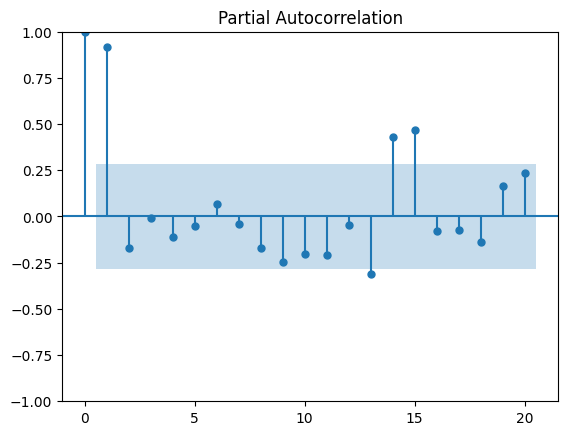

In [ ]:
plot_pacf(first_agency_smoothed_monthly['total_amount'], lags=20);

### ADF is bigger than the 5% so:

In [ ]:
diff_close = np.diff(first_agency_smoothed_monthly['total_amount'], n=1)

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(diff_close)

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -8.610322802612137
p-value: 6.502253448333994e-14


{'1%': -3.5812576580093696,
 '5%': -2.9267849124681518,
 '10%': -2.6015409829867675}

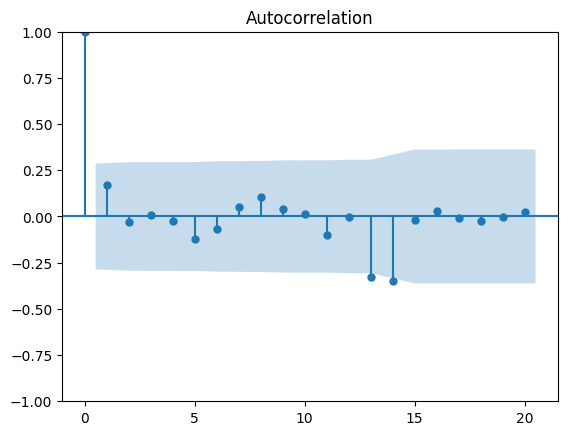

In [ ]:
plot_acf(diff_close, lags=20);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



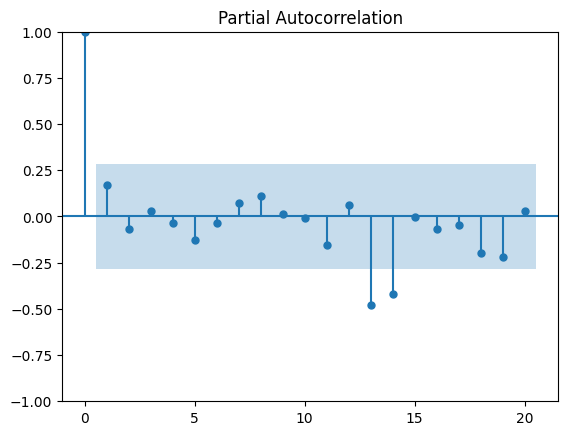

In [ ]:
plot_pacf(diff_close, lags=20);

### Second Agency:

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(second_agency_smoothed_monthly['total_amount'])

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -2.150321124873322
p-value: 0.2247671925054061


{'1%': -3.5812576580093696,
 '5%': -2.9267849124681518,
 '10%': -2.6015409829867675}

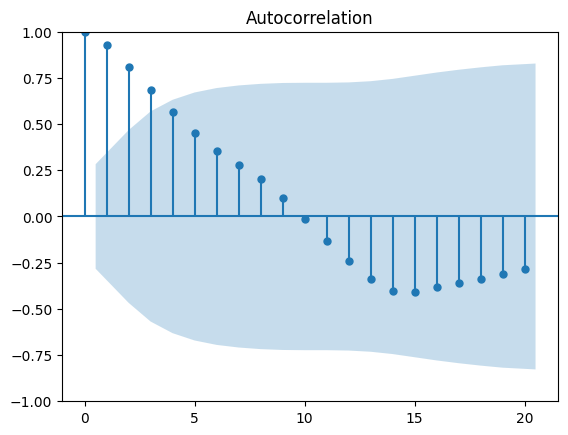

In [ ]:
plot_acf(second_agency_smoothed_monthly['total_amount'], lags=20);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


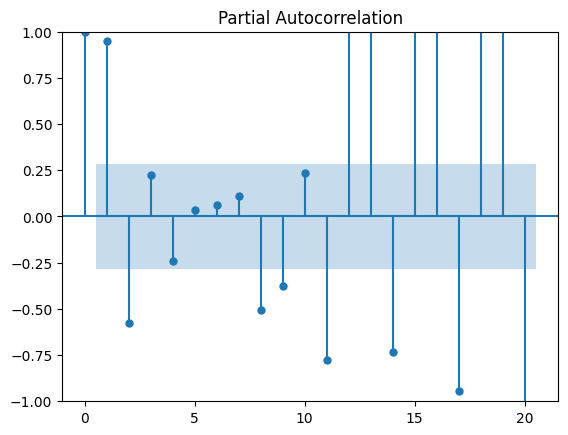

In [ ]:
plot_pacf(second_agency_smoothed_monthly['total_amount'], lags=20);

### ADF is bigger than the 5% so:

In [ ]:
diff_close = np.diff(second_agency_smoothed_monthly['total_amount'], n=1)

In [ ]:
test, p_value, _, _, critical_values, _ = stattools.adfuller(diff_close)

print(f'ADF Statistic: {test}')
print(f'p-value: {p_value}')
critical_values

ADF Statistic: -5.045283949481491
p-value: 1.8041363601569686e-05


{'1%': -3.5812576580093696,
 '5%': -2.9267849124681518,
 '10%': -2.6015409829867675}

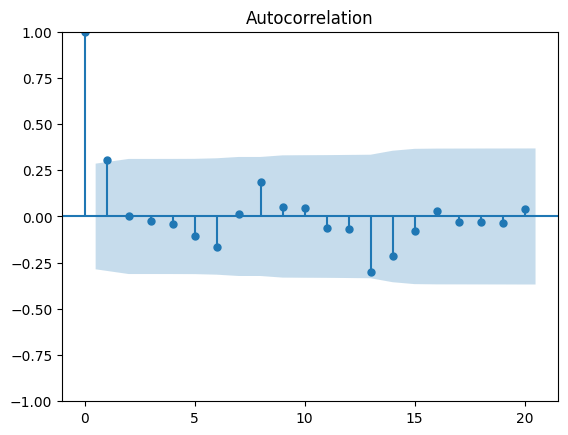

In [ ]:
plot_acf(diff_close, lags=20);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


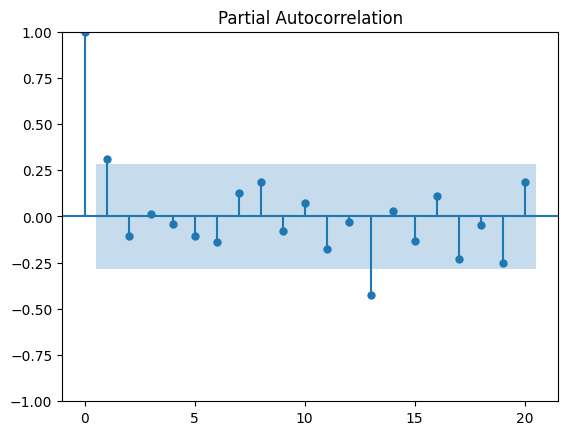

In [ ]:
plot_pacf(diff_close, lags=20);

## 3.8

In [ ]:
first_agency_smoothed_in_week=first_agency.rolling(168).mean().dropna()

In [ ]:
fig =  go.Figure()
# fig.update_layout(height=400, **layout_options)
fig.add_trace(go.Scatter(x=first_agency_smoothed_in_week.index, y=first_agency_smoothed_in_week['total_amount'], mode='lines',
               name='mean over a week'))

#


In [ ]:
second_agency_smoothed_in_week=second_agency.rolling(168).mean().dropna()

In [ ]:
fig =  go.Figure()
# fig.update_layout(height=400, **layout_options)
fig.add_trace(go.Scatter(x=second_agency_smoothed_in_week.index, y=second_agency_smoothed_in_week['total_amount'], mode='lines',
               name='mean over a week'))


## 3.9

### Line Chart on the Monthly Data For The First Agency:

In [ ]:
fig =  go.Figure()
# fig.update_layout(height=400, **layout_options)

fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly.index, y=first_agency_smoothed_monthly['total_amount'], mode='lines',
                         name='Monthly Mean'))



### Line Chart on the Monthly Data For The Second Agency:

In [ ]:
fig =  go.Figure()
# fig.update_layout(height=400, **layout_options)

fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly.index, y=second_agency_smoothed_monthly['total_amount'], mode='lines',
                         name='Monthly Mean'))

# 3 .b

### Using additive model:

#### For First Agency Total Amount:

In [ ]:
first_agency_smoothed_monthly_no_index=first_agency_smoothed_monthly.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(first_agency_smoothed_monthly_no_index['total_amount'], period=4,
                                     model='additive')

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'total_amount'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=first_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='total_amount Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='total_amount Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='total_amount irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For First Agency Number Of Journeys:


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(first_agency_smoothed_monthly_no_index['number_of_journeys'], period=4,
                                     model='additive')

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'number_of_journeys'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=first_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='number_of_journeys'), row=1, col=1)

fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='number_of_journeys Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='number_of_journeys Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='number_of_journeys irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For Second Agency Total Amount:

In [ ]:
second_agency_smoothed_monthly_no_index=second_agency_smoothed_monthly.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(second_agency_smoothed_monthly_no_index['total_amount'], period=4,
                                     model='additive')
#multiplicative

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'total_amount'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=second_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='total_amount Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='total_amount Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='total_amount irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For Second Agency Number Of Journeys:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(second_agency_smoothed_monthly_no_index['number_of_journeys'], period=4,
                                     model='additive')
#multiplicative

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'number_of_journeys'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=second_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='number_of_journeys Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='number_of_journeys Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='number_of_journeys irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

### multiplicative model:


#### For First Agency Total Amount:

In [ ]:
first_agency_smoothed_monthly_no_index=first_agency_smoothed_monthly.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(first_agency_smoothed_monthly_no_index['total_amount'], period=4,
                                     model='multiplicative')

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'total_amount'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=first_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='total_amount Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='total_amount Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='total_amount irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For First Agency Number Of Journeys:


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(first_agency_smoothed_monthly_no_index['number_of_journeys'], period=4,
                                     model='multiplicative')

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'number_of_journeys'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=first_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='number_of_journeys'), row=1, col=1)

fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='number_of_journeys Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='number_of_journeys Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=first_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='number_of_journeys irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For Second Agency Total Amount:

In [ ]:
second_agency_smoothed_monthly_no_index=second_agency_smoothed_monthly.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(second_agency_smoothed_monthly_no_index['total_amount'], period=4,
                                     model='multiplicative')
#multiplicative

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'total_amount'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=second_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='total_amount Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='total_amount Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='total_amount irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

#### For Second Agency Number Of Journeys:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_model = seasonal_decompose(second_agency_smoothed_monthly_no_index['number_of_journeys'], period=4,
                                     model='multiplicative')
#multiplicative

In [ ]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

In [ ]:
from plotly.subplots import make_subplots

time_column = 'date'
readings_column = 'number_of_journeys'

fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=second_agency_smoothed_monthly_no_index[readings_column],
                         mode='lines', name='total_amount'), row=1, col=1)

fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.trend,
                         mode='lines',
               name='number_of_journeys Trend'), row=2, col=1)


fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column], y=decompose_model.seasonal,
                         mode='lines',
               name='number_of_journeys Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=second_agency_smoothed_monthly_no_index[time_column],
                         y=decompose_model.resid,
                         mode='lines',
               name='number_of_journeys irregular variations'), row=4, col=1)
fig.update_layout(width=750, **layout_options)
fig.update_yaxes(**layout_options['yaxis'])
fig.update_xaxes(visible=False)

### Using Prophet Model:

In [ ]:
from prophet import Prophet

#### For Vendor 1:

In [83]:
first_agency_smoothed_daily.reset_index(inplace=True)

#### try prophet with future data is known:

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(first_agency_smoothed_daily.date,first_agency_smoothed_daily.total_amount,test_size=0.25,shuffle=False)

In [ ]:
m = Prophet()
m.fit(pd.DataFrame({'ds':x_train,'y':y_train}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbswoznl7/u2bjerg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbswoznl7/e9z7ykmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11876', 'data', 'file=/tmp/tmpbswoznl7/u2bjerg7.json', 'init=/tmp/tmpbswoznl7/e9z7ykmy.json', 'output', 'file=/tmp/tmpbswoznl7/prophet_modelyh9o4mh_/prophet_model-20230619153419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### try prophet with future unkown data :

In [ ]:
m = Prophet()
m.fit(first_agency_smoothed_daily.rename(columns={'date':'ds','total_amount':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbswoznl7/x82sycdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbswoznl7/dhb2_r1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21066', 'data', 'file=/tmp/tmpbswoznl7/x82sycdd.json', 'init=/tmp/tmpbswoznl7/dhb2_r1h.json', 'output', 'file=/tmp/tmpbswoznl7/prophet_model8k166_8i/prophet_model-20230619153510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
future

ds
0    2019-01-01
1    2019-01-02
2    2019-01-03
3    2019-01-04
4    2019-01-05
...         ...
1821 2023-12-27
1822 2023-12-28
1823 2023-12-29
1824 2023-12-30
1825 2023-12-31

[1826 rows x 1 columns]

In [ ]:
forecast = m.predict(future)

In [ ]:
# from sklearn.metrics import r2_score
# score = r2_score(forecast.iloc[-365:]["yhat"], y_test)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

#### plot predicted values

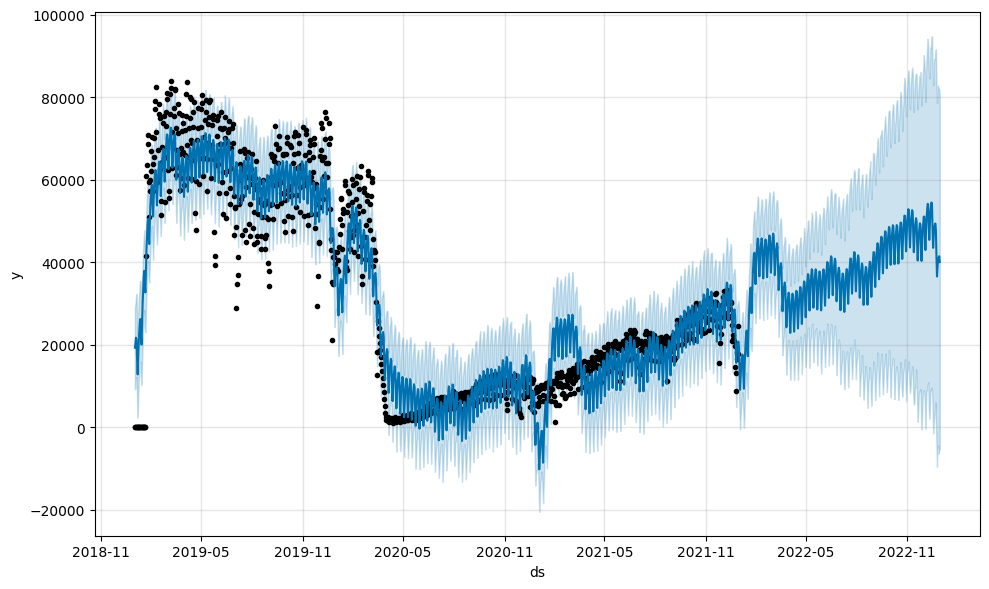

In [ ]:
fig1 = m.plot(forecast)

#### plot real_values:

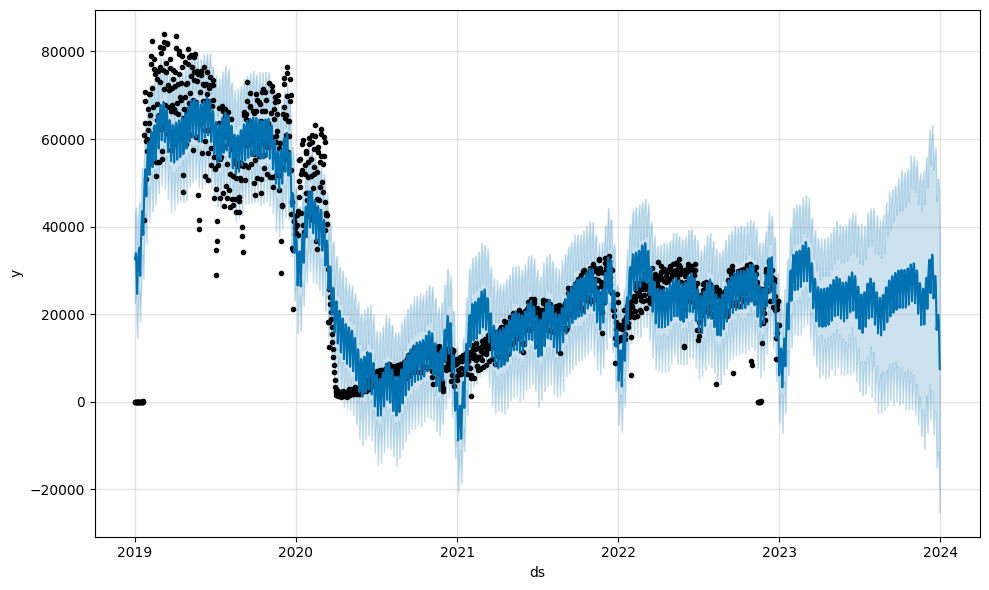

In [ ]:
fig1 = m.plot(forecast)

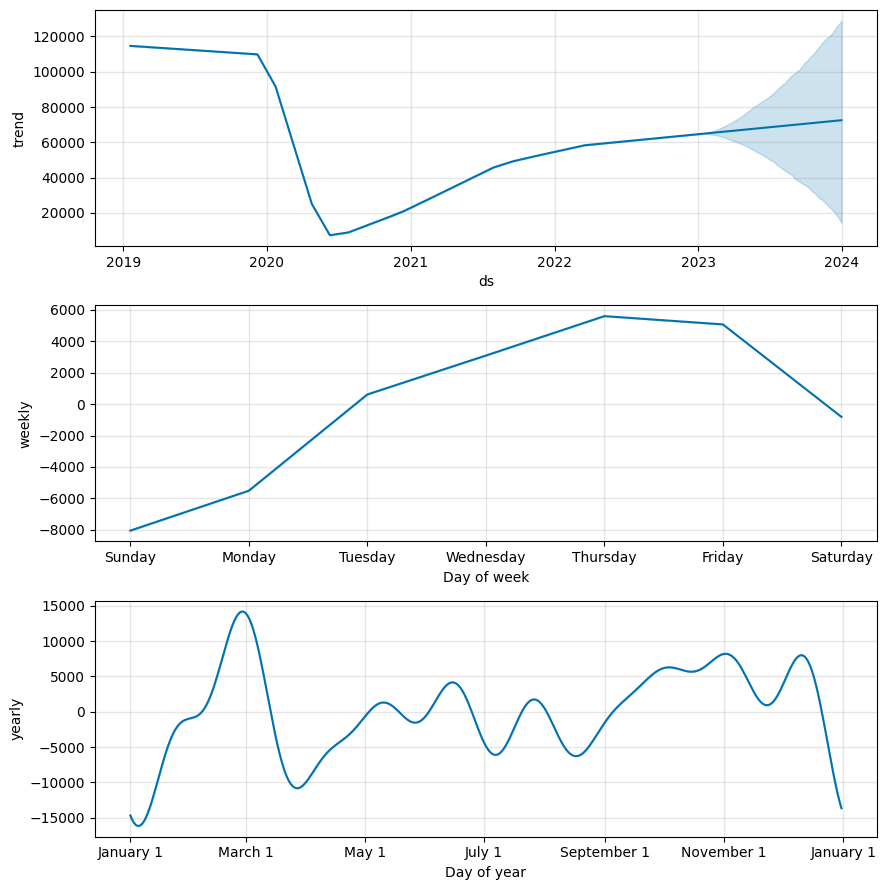

In [ ]:
fig2 = m.plot_components(forecast)

#### For Vendor 2:

In [ ]:
second_agency_smoothed_daily.reset_index(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(second_agency_smoothed_daily.date,second_agency_smoothed_daily.total_amount,test_size=0.25,shuffle=False)

#### try prophet with future known data :

In [ ]:
m = Prophet()
m.fit(pd.DataFrame({'ds':x_train,'y':y_train}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdnescqh/v6s8_5t6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdnescqh/txajgfmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41146', 'data', 'file=/tmp/tmpfdnescqh/v6s8_5t6.json', 'init=/tmp/tmpfdnescqh/txajgfmb.json', 'output', 'file=/tmp/tmpfdnescqh/prophet_modeldaexps5k/prophet_model-20230620112633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### try prophet with future unkown data :

In [ ]:
m = Prophet()
m.fit(second_agency_smoothed_daily.rename(columns={'date':'ds','total_amount':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdnescqh/9tq1jnf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdnescqh/4w4opmtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71354', 'data', 'file=/tmp/tmpfdnescqh/9tq1jnf1.json', 'init=/tmp/tmpfdnescqh/4w4opmtk.json', 'output', 'file=/tmp/tmpfdnescqh/prophet_modelrjp4685j/prophet_model-20230620112704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:27:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=366)
future

ds
0    2019-01-19
1    2019-01-20
2    2019-01-21
3    2019-01-22
4    2019-01-23
...         ...
1804 2023-12-28
1805 2023-12-29
1806 2023-12-30
1807 2023-12-31
1808 2024-01-01

[1809 rows x 1 columns]

In [ ]:
forecast = m.predict(future)

In [ ]:
len(y_test)

361

In [ ]:
# from sklearn.metrics import r2_score
# score = r2_score(forecast.iloc[-361:]["yhat"], y_test)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

#### plot real_values (2022 -2023) values is real:

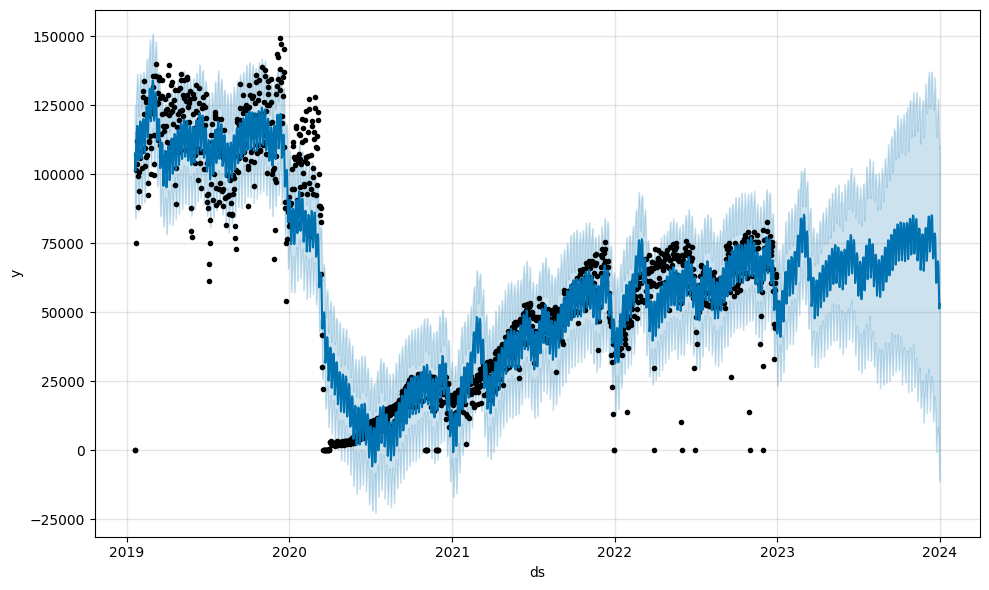

In [ ]:
fig1 = m.plot(forecast)

#### plot predicted values(2022-2023) values is predicted so we can compare it with the real one above

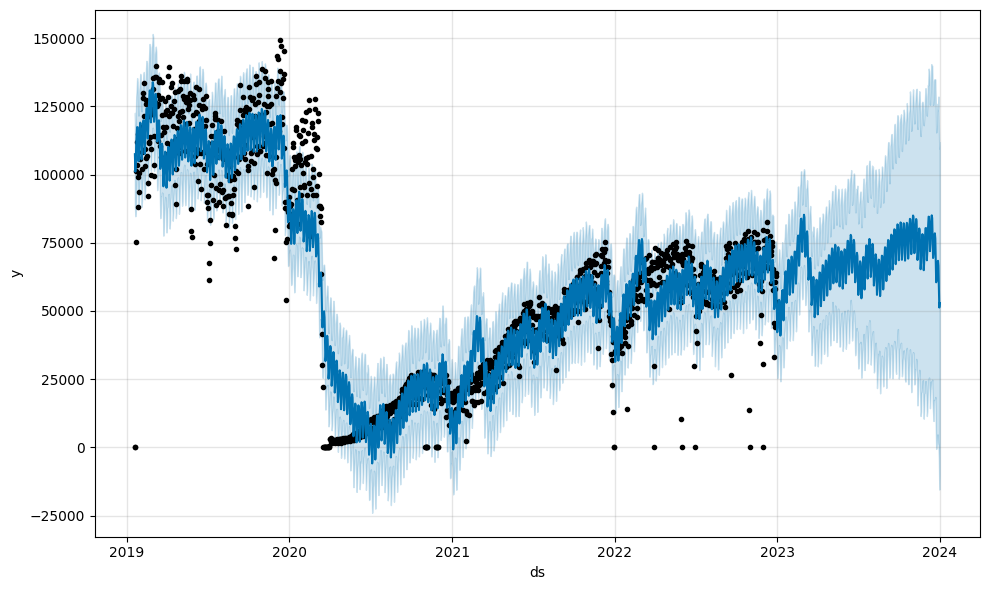

In [ ]:
fig1 = m.plot(forecast)

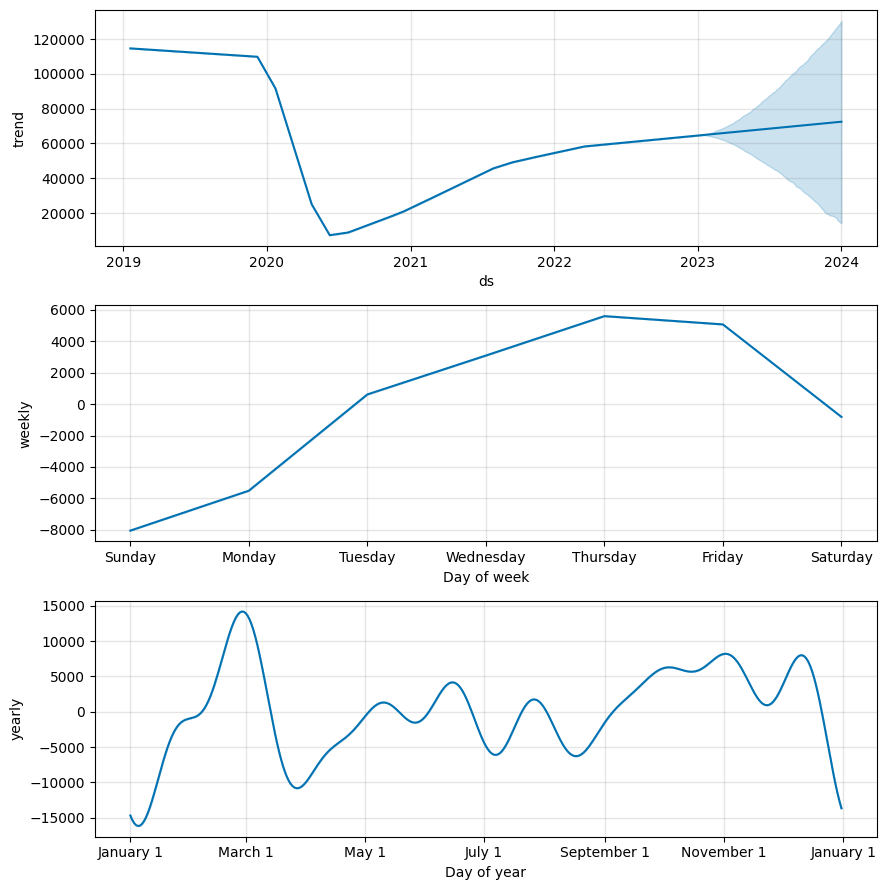

In [ ]:
fig2 = m.plot_components(forecast)

# 3.c

## First Agency:

### ARMA-autoregressive(3.0.0):

In [ ]:
first_agency_diff=np.diff(first_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': first_agency_diff})


In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon
    end_idx = train_len
    pred_AR = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(3,0,0))
        res = model.fit()
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_AR.extend(oos_pred)

    return pred_AR

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW)
pred_df['pred_MA'] = pred_MA

pred_df.head()

total_amount_diff      pred_MA
1314        2953.918333   -73.613183
1315        2323.674167  1947.776662
1316      -20625.789167   426.476092
1317       22087.238750 -6429.319197
1318       -1362.185000  9829.227369

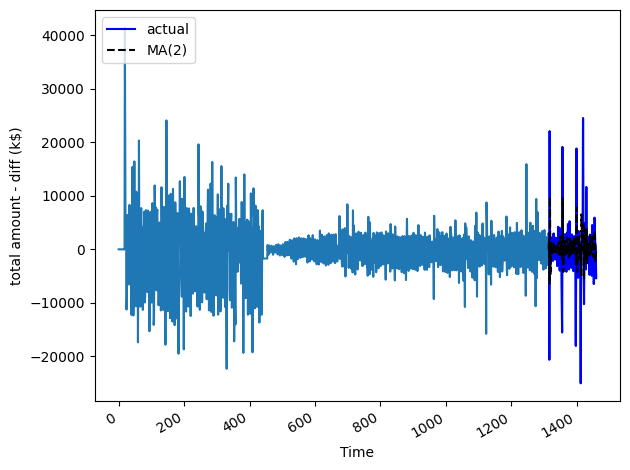

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['total_amount_diff'])
ax.plot(pred_df['total_amount_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('total amount - diff (k$)')

# ax.axvspan(449, 498, color='#808080', alpha=0.2)

# ax.set_xlim(430, 500)

# plt.xticks(
#     [439, 468, 498],
#     ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
mean_squared_error(pred_df['total_amount_diff'], pred_df['pred_MA'])

34226370.59066677

In [ ]:
first_agency_smoothed_daily['pred_total_amount'] = pd.Series()
first_agency_smoothed_daily['pred_total_amount'][TRAIN_LEN+1:] = first_agency_smoothed_daily['total_amount'].iloc[TRAIN_LEN+1] + pred_df['pred_MA'].cumsum()

<ipython-input-16-07cc732c6daa>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  first_agency_smoothed_daily['pred_total_amount'] = pd.Series()


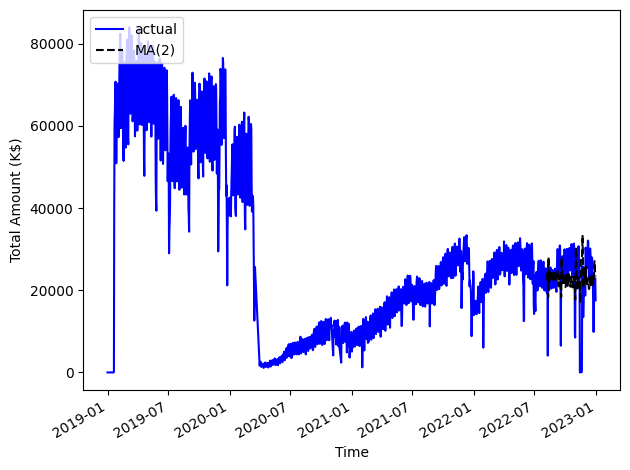

In [ ]:
fig, ax = plt.subplots()

ax.plot(first_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(first_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### ARMA using order (8,0,1):

In [ ]:
first_agency_diff=np.diff(first_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': first_agency_diff})

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)
train=train.values
test=test.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
 model = ARIMA(history, order=(8,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 6222.175


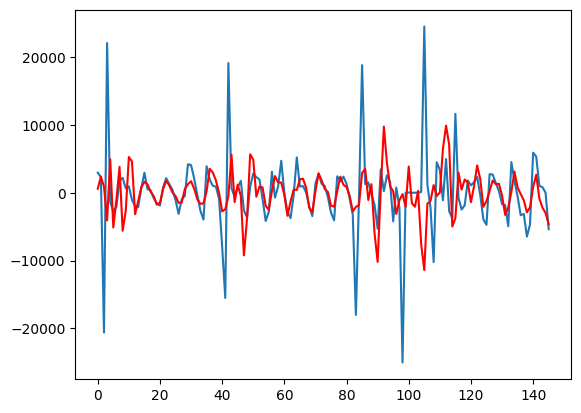

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
first_agency_smoothed_daily['pred_total_amount'] = pd.Series()
first_agency_smoothed_daily['pred_total_amount'][len(train)+1:] = first_agency_smoothed_daily['total_amount'].iloc[len(train)+1] + predictions

<ipython-input-381-65078316ddbe>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



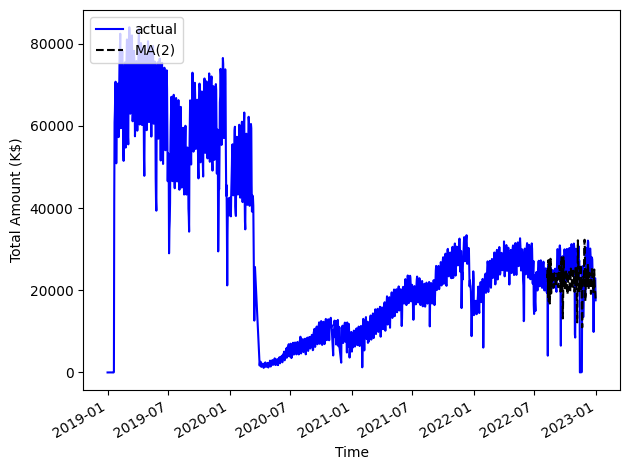

In [ ]:
fig, ax = plt.subplots()

ax.plot(first_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(first_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### ARMA using order (5,0,1) "Best Model":

In [ ]:
first_agency_diff=np.diff(first_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': first_agency_diff})

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)
train=train.values
test=test.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
 model = ARIMA(history, order=(5,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 6930.832


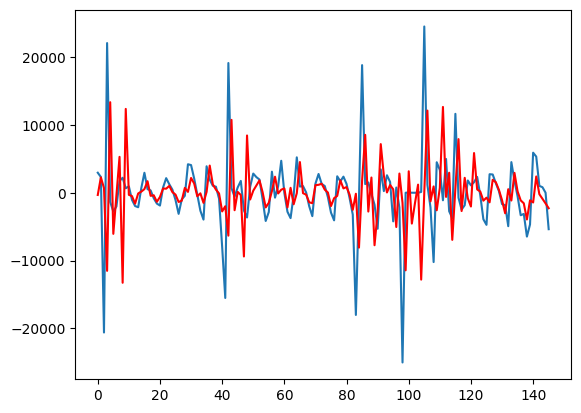

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
first_agency_smoothed_daily['pred_total_amount'] = pd.Series()
first_agency_smoothed_daily['pred_total_amount'][len(train)+1:] = first_agency_smoothed_daily['total_amount'].iloc[len(train)+1] + predictions

<ipython-input-376-65078316ddbe>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



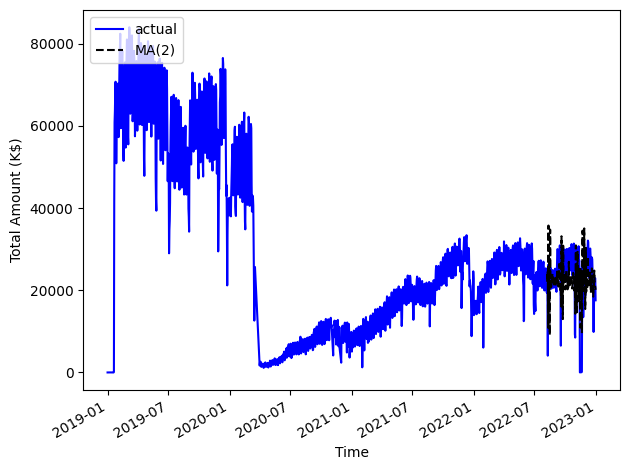

In [ ]:
fig, ax = plt.subplots()

ax.plot(first_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(first_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

## Second Agency:

### ARMA-autoregressive moving average with order(3.0.0):

In [ ]:
second_agency_diff=np.diff(second_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': second_agency_diff})


In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon
    end_idx = train_len
    pred_AR = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(3,0,0))
        res = model.fit()
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_AR.extend(oos_pred)

    return pred_AR

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW)
pred_df['pred_MA'] = pred_MA

pred_df.head()

total_amount_diff      pred_MA
1297        7056.758333  2344.772581
1298        1333.315417  1900.308151
1299        1790.021250 -1913.438193
1300       -3420.431250 -1455.217877
1301       -4211.155417 -1218.113577

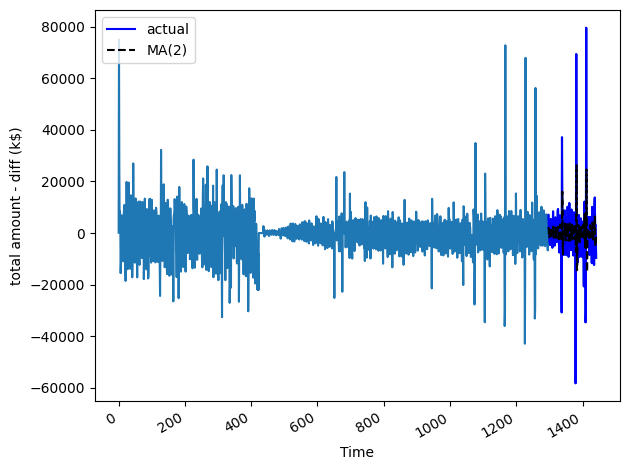

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['total_amount_diff'])
ax.plot(pred_df['total_amount_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('total amount - diff (k$)')

# ax.axvspan(449, 498, color='#808080', alpha=0.2)

# ax.set_xlim(430, 500)

# plt.xticks(
#     [439, 468, 498],
#     ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
mean_squared_error(pred_df['total_amount_diff'], pred_df['pred_MA'])

158596308.25076103

In [ ]:
second_agency_smoothed_daily['pred_total_amount'] = pd.Series()
second_agency_smoothed_daily['pred_total_amount'][TRAIN_LEN+1:] = second_agency_smoothed_daily['total_amount'].iloc[TRAIN_LEN+1] + pred_df['pred_MA'].cumsum()

<ipython-input-87-934b5206ba64>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-87-934b5206ba64>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



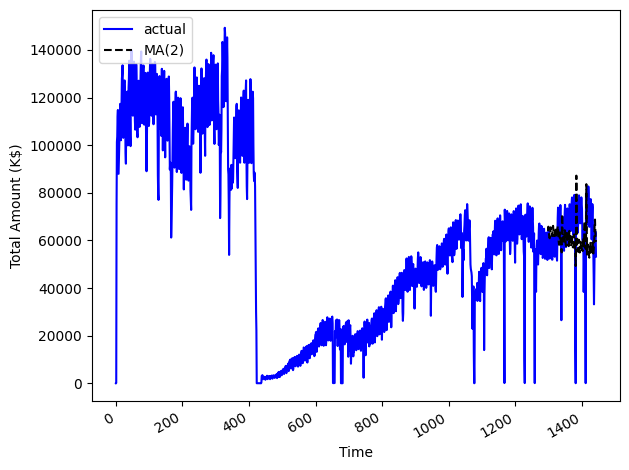

In [ ]:
fig, ax = plt.subplots()

ax.plot(second_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(second_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### ARMA using order (8,0,1):

In [ ]:
second_agency_diff=np.diff(second_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': second_agency_diff})

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)
train=train.values
test=test.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
 model = ARIMA(history, order=(8,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 12638.723


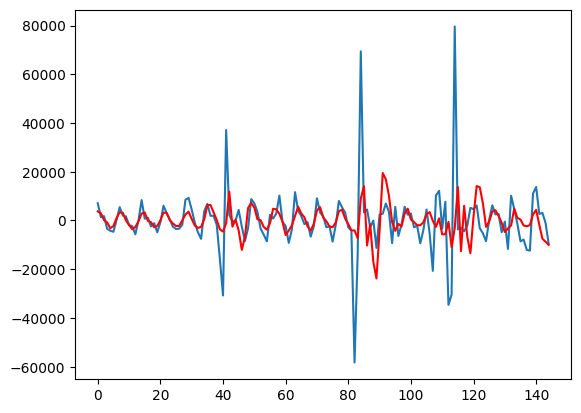

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
second_agency_smoothed_daily['pred_total_amount'] = pd.Series()
second_agency_smoothed_daily['pred_total_amount'][len(train)+1:] = second_agency_smoothed_daily['total_amount'].iloc[len(train)+1] + predictions

<ipython-input-93-42a08d5768e2>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-93-42a08d5768e2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



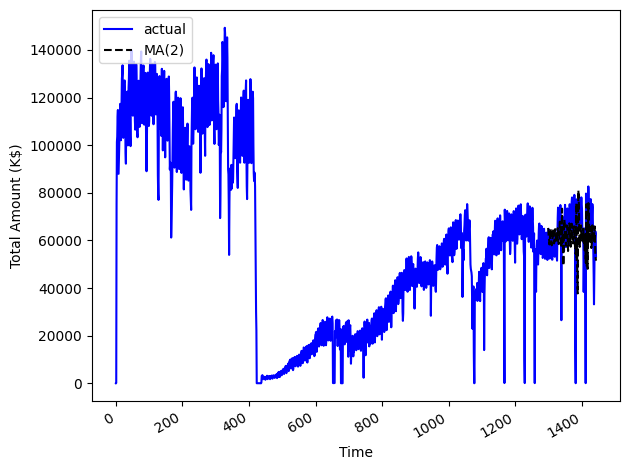

In [ ]:
fig, ax = plt.subplots()

ax.plot(second_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(second_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### ARMA using order (5,0,1) "Best Model":

In [ ]:
second_agency_diff=np.diff(second_agency_smoothed_daily['total_amount'],n=1)
df_diff = pd.DataFrame({'total_amount_diff': second_agency_diff})

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_diff,test_size=0.1,shuffle=False)
train=train.values
test=test.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 14320.741


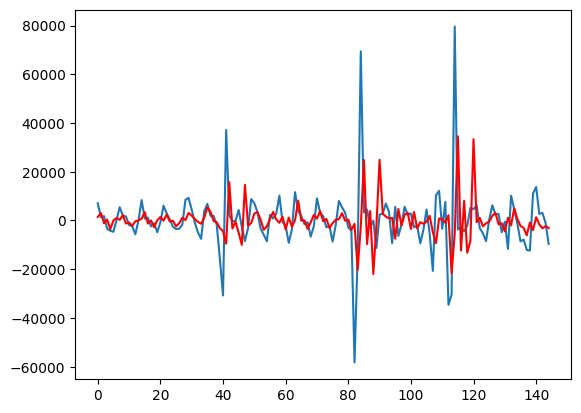

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
second_agency_smoothed_daily['pred_total_amount'] = pd.Series()
second_agency_smoothed_daily['pred_total_amount'][len(train)+1:] = second_agency_smoothed_daily['total_amount'].iloc[len(train)+1] + predictions

<ipython-input-99-42a08d5768e2>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-99-42a08d5768e2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



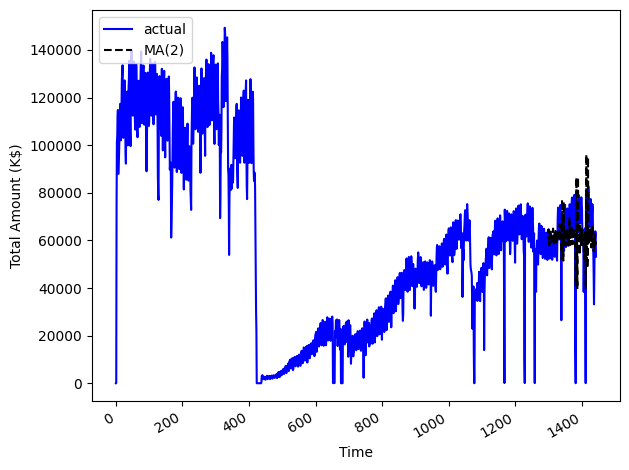

In [ ]:
fig, ax = plt.subplots()

ax.plot(second_agency_smoothed_daily['total_amount'], 'b-', label='actual')
ax.plot(second_agency_smoothed_daily['pred_total_amount'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Total Amount (K$)')

# ax.axvspan(450, 500, color='#808080', alpha=0.2)

# ax.set_xlim(400, 500)

# plt.xticks(
#     [409, 439, 468, 498],
#     ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [84]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/final.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/final.ipynb to html
[NbConvertApp] Writing 6436520 bytes to /content/drive/MyDrive/final.html
